# Sklearn

### Libs

In [0]:
import scipy
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import linear_model, metrics, preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load data

In [0]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/day_2/datasets/bike_sharing_demand.csv', header = 0, sep = ',')

In [0]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Data preprocessing

#### Train and hold out test

In [0]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [0]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [0]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [0]:
print raw_data.shape, train_data.shape, hold_out_test_data.shape

(10886, 14) (9886, 14) (1000, 14)


In [0]:
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [0]:
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [0]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

Now we will work with all features - not with only numeric as in first lesson

In [0]:
print binary_data_columns
print binary_data_indices

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [0]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [0]:
print categorical_data_columns
print categorical_data_indices

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [0]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [0]:
print numeric_data_columns
print numeric_data_indices

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [0]:
regressor = linear_model.SGDRegressor(random_state = 0, n_iter = 3, loss = 'squared_loss', penalty = 'l2')

In [0]:
estimator = Pipeline(steps = [       
    ('feature_processing', FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [0]:
estimator.fit(train_data, train_labels)

In [0]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.17177172806858

Data preprocessing hasnt helped as a lot. Let's see if params search will help

### Params search

In [0]:
estimator.get_params().keys()

In [0]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [0]:
grid_cv = GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [0]:
%%time
grid_cv.fit(train_data, train_labels)

In [0]:
print grid_cv.best_score_
print grid_cv.best_params_

-106.60193979729921
{'model_fitting__eta0': 0.05, 'model_fitting__alpha': 0.001}


### Train and predict

In [0]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [0]:
metrics.mean_absolute_error(test_labels, test_predictions)

125.11055616822885

In [0]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [0]:
print test_predictions[:20]

[153.28859124 181.89867268 227.64068051 262.47727954 278.91095558
 279.82091706 301.6223314  333.35079391 336.28447325 348.55425173
 346.29477487 336.77206344 318.29674096 298.65247956 285.35831745
 246.0338046  252.72004984  58.96734361  66.43816405  73.90898448]


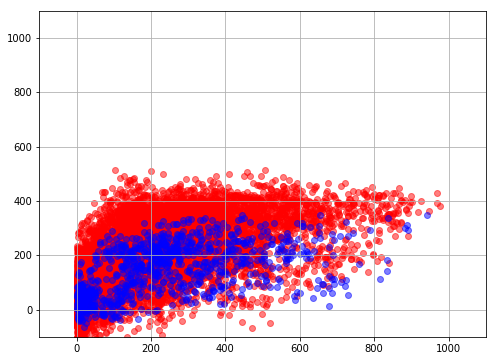

In [0]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

Still bad. Guess the problem is in the model. Let's try to change our model to non linear one.

### New model

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [0]:
estimator = Pipeline(steps = [       
    ('feature_processing', FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [0]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=None,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x7f9fbc3b02a8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='dep...timators=50, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [0]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.49758619912876

In [0]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446])

In [0]:
estimator.predict(test_data)[:10]

array([409.565     , 505.56      , 256.06066667, 165.6502619 ,
       205.82474784, 265.91960439, 254.61615818, 317.85774486,
       280.98963263, 434.51333333])

Text(0.5,1,'random forest model')

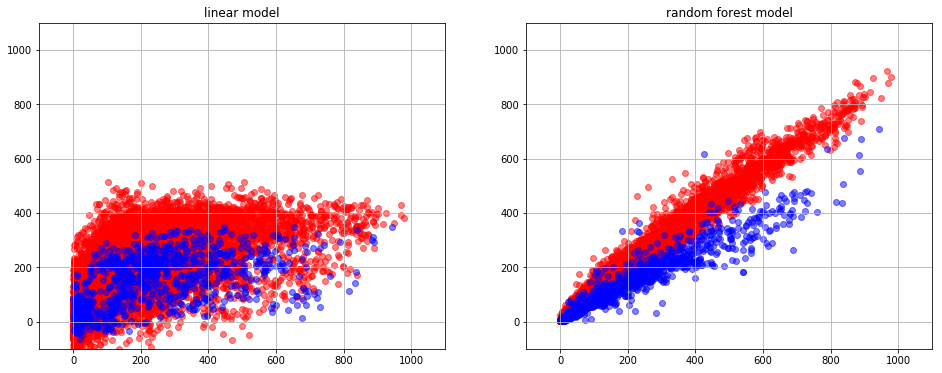

In [0]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')

it's obvious, that our new model is better ^_^ We will discuss non linear models on next week.